In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

2021-08-06 16:35:52.454967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-06 16:35:52.454984: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

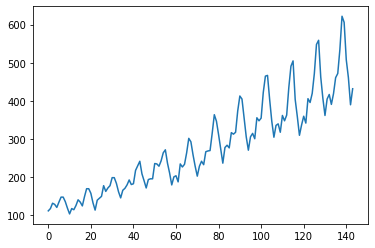

In [3]:
dataframe = pandas.read_csv('data/airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataframe)
plt.show()

In [4]:
array = dataframe['Passengers'].to_numpy().astype('float32')
n_samples = len(array)
array

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
normalized_array = scaler.fit_transform(array.reshape(-1, 1)).reshape(-1)
normalized_array

array([0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
       0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753,
       0.        , 0.02702703, 0.02123553, 0.04247104, 0.07142857,
       0.05984557, 0.04054055, 0.08687258, 0.12741312, 0.12741312,
       0.10424709, 0.05598456, 0.01930502, 0.06949806, 0.07915059,
       0.08880308, 0.14285713, 0.11389962, 0.13127413, 0.14285713,
       0.18339768, 0.18339768, 0.15444016, 0.11196911, 0.08108109,
       0.1196911 , 0.12934363, 0.14671814, 0.17181468, 0.14864865,
       0.15250966, 0.22007722, 0.24324325, 0.26640925, 0.2027027 ,
       0.16795367, 0.13127413, 0.17374519, 0.17760617, 0.17760617,
       0.25482625, 0.25289574, 0.24131274, 0.26833975, 0.3088803 ,
       0.32432434, 0.25675675, 0.20656371, 0.14671814, 0.18725869,
       0.19305018, 0.16216215, 0.25289574, 0.23745173, 0.25096524,
       0.3088803 , 0.38223937, 0.36486486, 0.2992278 , 0.24131274,
       0.1911197 , 0.24131274, 0.26640925, 0.24903473, 0.31467

In [6]:
# split into train and test sets
train_size = int(n_samples * 0.67)
test_size = n_samples - train_size
train, test = normalized_array[:train_size], normalized_array[train_size:]
print(len(train), len(test))

96 48


In [7]:
def rolling_window(a: np.array, window: int) -> np.array:
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [8]:
input_size = 10
train_x = rolling_window(train, input_size)[:-1]  # We don't have the label for the last sequence so we discard it
test_x = rolling_window(test, input_size)[:-1]
print(len(train_x), len(test_x))

86 38


In [9]:
train_y = train[input_size:]
test_y = test[input_size:]
print(len(train_y), len(test_y))

86 38


In [10]:
train_x

array([[0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
        0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753],
       [0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984557,
        0.08494207, 0.08494207, 0.06177607, 0.02895753, 0.        ],
       [0.05405405, 0.04826255, 0.03281853, 0.05984557, 0.08494207,
        0.08494207, 0.06177607, 0.02895753, 0.        , 0.02702703],
       [0.04826255, 0.03281853, 0.05984557, 0.08494207, 0.08494207,
        0.06177607, 0.02895753, 0.        , 0.02702703, 0.02123553],
       [0.03281853, 0.05984557, 0.08494207, 0.08494207, 0.06177607,
        0.02895753, 0.        , 0.02702703, 0.02123553, 0.04247104],
       [0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753,
        0.        , 0.02702703, 0.02123553, 0.04247104, 0.07142857],
       [0.08494207, 0.08494207, 0.06177607, 0.02895753, 0.        ,
        0.02702703, 0.02123553, 0.04247104, 0.07142857, 0.05984557],
       [0.08494207, 0.06177607, 0.0289575

In [11]:
# reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
train_x

array([[[0.01544401],
        [0.02702703],
        [0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984557],
        [0.08494207],
        [0.08494207],
        [0.06177607],
        [0.02895753]],

       [[0.02702703],
        [0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984557],
        [0.08494207],
        [0.08494207],
        [0.06177607],
        [0.02895753],
        [0.        ]],

       [[0.05405405],
        [0.04826255],
        [0.03281853],
        [0.05984557],
        [0.08494207],
        [0.08494207],
        [0.06177607],
        [0.02895753],
        [0.        ],
        [0.02702703]],

       [[0.04826255],
        [0.03281853],
        [0.05984557],
        [0.08494207],
        [0.08494207],
        [0.06177607],
        [0.02895753],
        [0.        ],
        [0.02702703],
        [0.02123553]],

       [[0.03281853],
        [0.05984557],
        [0.08494207],
        [0.08494207],
        [0.06177607],
  

In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=500, batch_size=1, verbose=2)

Epoch 1/500
86/86 - 1s - loss: 0.0272
Epoch 2/500
86/86 - 0s - loss: 0.0084
Epoch 3/500
86/86 - 0s - loss: 0.0063
Epoch 4/500
86/86 - 0s - loss: 0.0055
Epoch 5/500
86/86 - 0s - loss: 0.0056
Epoch 6/500
86/86 - 0s - loss: 0.0054
Epoch 7/500
86/86 - 0s - loss: 0.0052
Epoch 8/500
86/86 - 0s - loss: 0.0051
Epoch 9/500
86/86 - 0s - loss: 0.0048
Epoch 10/500
86/86 - 0s - loss: 0.0049
Epoch 11/500
86/86 - 0s - loss: 0.0047
Epoch 12/500
86/86 - 0s - loss: 0.0050
Epoch 13/500
86/86 - 0s - loss: 0.0046
Epoch 14/500
86/86 - 0s - loss: 0.0048
Epoch 15/500
86/86 - 0s - loss: 0.0046
Epoch 16/500
86/86 - 0s - loss: 0.0048
Epoch 17/500
86/86 - 0s - loss: 0.0045
Epoch 18/500
86/86 - 0s - loss: 0.0044
Epoch 19/500
86/86 - 0s - loss: 0.0047
Epoch 20/500
86/86 - 0s - loss: 0.0042
Epoch 21/500
86/86 - 0s - loss: 0.0043
Epoch 22/500
86/86 - 0s - loss: 0.0043
Epoch 23/500
86/86 - 0s - loss: 0.0043
Epoch 24/500
86/86 - 0s - loss: 0.0043
Epoch 25/500
86/86 - 0s - loss: 0.0041
Epoch 26/500
86/86 - 0s - loss: 0.

Epoch 209/500
86/86 - 0s - loss: 0.0017
Epoch 210/500
86/86 - 0s - loss: 0.0017
Epoch 211/500
86/86 - 0s - loss: 0.0016
Epoch 212/500
86/86 - 0s - loss: 0.0017
Epoch 213/500
86/86 - 0s - loss: 0.0015
Epoch 214/500
86/86 - 0s - loss: 0.0016
Epoch 215/500
86/86 - 0s - loss: 0.0015
Epoch 216/500
86/86 - 0s - loss: 0.0016
Epoch 217/500
86/86 - 0s - loss: 0.0016
Epoch 218/500
86/86 - 0s - loss: 0.0016
Epoch 219/500
86/86 - 0s - loss: 0.0016
Epoch 220/500
86/86 - 0s - loss: 0.0016
Epoch 221/500
86/86 - 0s - loss: 0.0016
Epoch 222/500
86/86 - 0s - loss: 0.0016
Epoch 223/500
86/86 - 0s - loss: 0.0016
Epoch 224/500
86/86 - 0s - loss: 0.0017
Epoch 225/500
86/86 - 0s - loss: 0.0016
Epoch 226/500
86/86 - 0s - loss: 0.0015
Epoch 227/500
86/86 - 0s - loss: 0.0016
Epoch 228/500
86/86 - 0s - loss: 0.0015
Epoch 229/500
86/86 - 0s - loss: 0.0015
Epoch 230/500
86/86 - 0s - loss: 0.0019
Epoch 231/500
86/86 - 0s - loss: 0.0016
Epoch 232/500
86/86 - 0s - loss: 0.0015
Epoch 233/500
86/86 - 0s - loss: 0.0015


Epoch 407/500
86/86 - 0s - loss: 7.2251e-04
Epoch 408/500
86/86 - 0s - loss: 7.4455e-04
Epoch 409/500
86/86 - 0s - loss: 8.0914e-04
Epoch 410/500
86/86 - 0s - loss: 7.7518e-04
Epoch 411/500
86/86 - 0s - loss: 7.4442e-04
Epoch 412/500
86/86 - 0s - loss: 7.3502e-04
Epoch 413/500
86/86 - 0s - loss: 7.8478e-04
Epoch 414/500
86/86 - 0s - loss: 7.0739e-04
Epoch 415/500
86/86 - 0s - loss: 7.0947e-04
Epoch 416/500
86/86 - 0s - loss: 7.0923e-04
Epoch 417/500
86/86 - 0s - loss: 7.6893e-04
Epoch 418/500
86/86 - 0s - loss: 6.8085e-04
Epoch 419/500
86/86 - 0s - loss: 7.0980e-04
Epoch 420/500
86/86 - 0s - loss: 6.9522e-04
Epoch 421/500
86/86 - 0s - loss: 7.0623e-04
Epoch 422/500
86/86 - 0s - loss: 7.4105e-04
Epoch 423/500
86/86 - 0s - loss: 6.9098e-04
Epoch 424/500
86/86 - 0s - loss: 6.5430e-04
Epoch 425/500
86/86 - 0s - loss: 7.3515e-04
Epoch 426/500
86/86 - 0s - loss: 7.1638e-04
Epoch 427/500
86/86 - 0s - loss: 7.0799e-04
Epoch 428/500
86/86 - 0s - loss: 6.7507e-04
Epoch 429/500
86/86 - 0s - loss:

In [19]:
# make predictions
train_predict = scaler.inverse_transform(model.predict(train_x))
test_predict = scaler.inverse_transform(model.predict(test_x))
train_y_inverted = scaler.inverse_transform([train_y])
test_y_inverted = scaler.inverse_transform([test_y])
# calculate root mean squared error
train_rmse = math.sqrt(mean_squared_error(train_y_inverted[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_rmse))
test_rmse = math.sqrt(mean_squared_error(test_y_inverted[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_rmse))


Train Score: 11.46 RMSE
Test Score: 78.87 RMSE


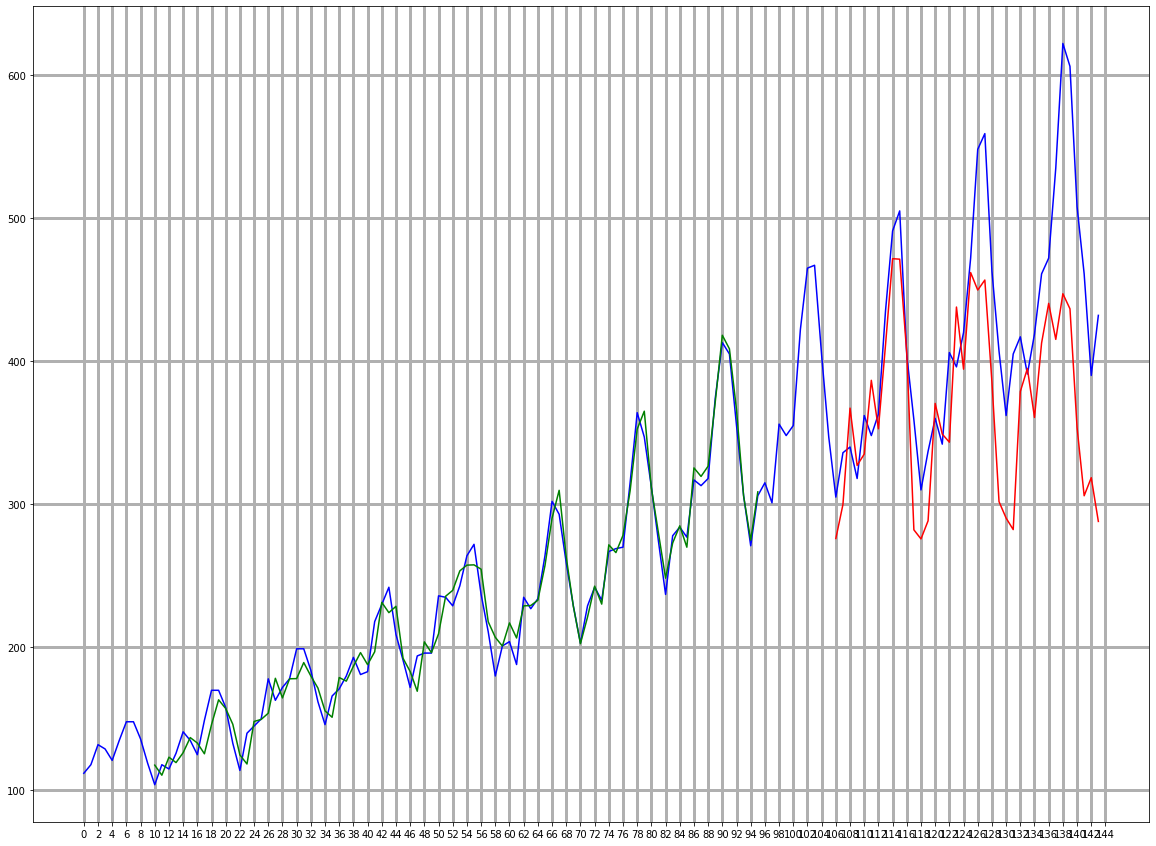

In [20]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(array.reshape(-1, 1))
train_predict_plot[:, :] = np.nan
train_predict_plot[input_size:len(train_predict)+input_size, :] = train_predict
# shift test predictions for plotting
test_predict_plot = np.empty_like(array.reshape(-1, 1))
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(input_size*2):len(array), :] = test_predict
# plot baseline and predictions
plt.subplots(figsize=(20, 15))
plt.plot(array, color='blue')
plt.plot(train_predict_plot, color='green')
plt.plot(test_predict_plot, color='red')
plt.grid(linewidth=3)
plt.xticks(np.arange(0,len(array)+1,2))
plt.show()